In [2]:
library(lubridate)
library(tidyverse)
library(mgcViz)
source('../Scripts/data_preparation.R')

In [3]:
theme_set(theme_minimal()+theme(text=element_text(family='Helvetica-Narrow')))

# Métriques

In [4]:
pinball <- function(y,prev,q){
    u <- y - prev
  if (u > 0){
    err <- q*u
  }else{
    err <- (q-1)*u
  }
  return(err)
}

RPS <- function(y,prev_quantile,niveau_quantile){
  sum <- 0
  niveau_quantile <- c(0,niveau_quantile,1)
  for (l in (1:9)){
    sum <- sum + pinball(y=y,prev=prev_quantile[,l][[1]],
                         q=niveau_quantile[l+1])*(niveau_quantile[l+2]-niveau_quantile[l])
  }
  return(sum)
}

nRPS <- function(Y,prevs_quantile,niveau_quantile){
  sum1 <- 0
  
  for (i in 1:length(Y)){
    sum1<- sum1 + RPS(Y[[i]],prevs_quantile[i,],niveau_quantile)
  }
  return(sum1/sum(abs(Y-mean(Y))))
}

In [5]:
pinball_loss <- function(y_true, y_pred, tau) {
  residuals <- y_true - y_pred
  pinball_loss_value <- mean(pmax(tau * residuals, (tau - 1) * residuals))
  return(pinball_loss_value)
}

In [6]:
couverture <- function(y_true, y_pred_q) {
  residuals <- y_true - y_pred_q
  cov <- sum(residuals < 0)/length(residuals)
  return(cov)
}

# Données

In [7]:
load <- readRDS('../Data/full_profile.RDS')
train_test_periods <- read_train_test_periods(train_file_path = '../Data/train_dates',
                                              test_file_path = '../Data/test_dates')
train_dates <- train_test_periods$train
test_dates <- train_test_periods$test

# Persistance 

In [8]:
Per_forecast <- load %>% group_by(Daytype, Tod) %>%
mutate(
    q10 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.1)[[1]]),
                         align = 'right', fill=NA),
    q20 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.2)[[1]]),
                         align = 'right', fill=NA),
    q30 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.3)[[1]]),
                         align = 'right', fill=NA),
    q40 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.4)[[1]]),
                         align = 'right', fill=NA),
    q50 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.5)[[1]]),
                         align = 'right', fill=NA),
    q60 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.6)[[1]]),
                         align = 'right', fill=NA),
    q70 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.7)[[1]]),
                         align = 'right', fill=NA),
    q80 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.8)[[1]]),
                         align = 'right', fill=NA),
    q90 = zoo::rollapply(Power, width=10, FUN = function(x) return(quantile(x[-length(x)], probs = 0.9)[[1]]),
                         align = 'right', fill=NA)) %>%
ungroup()

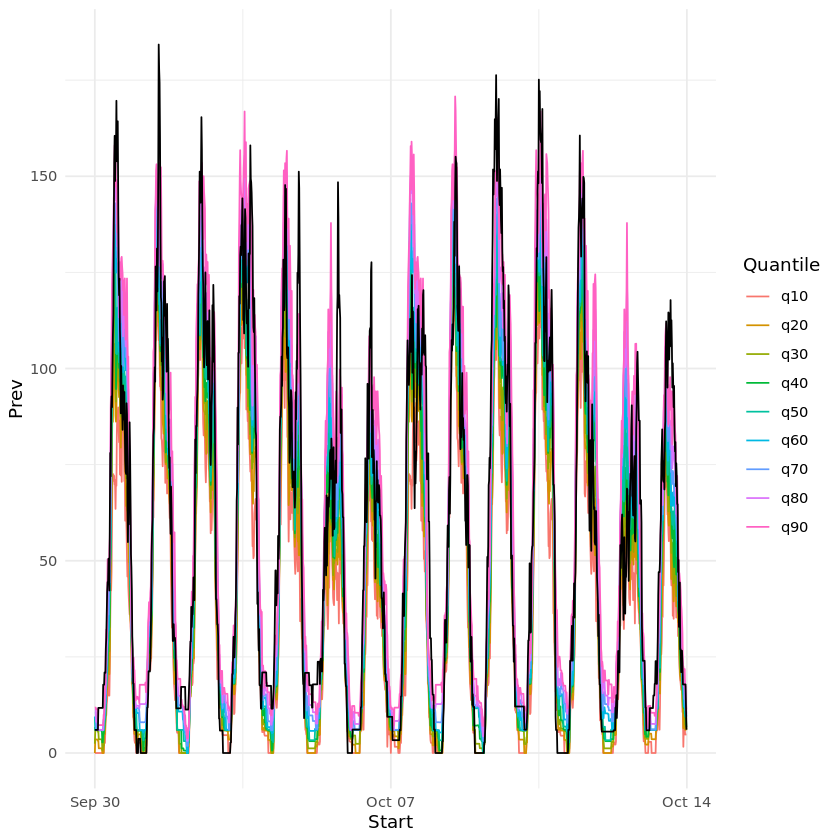

In [9]:
Per_forecast %>% filter(Start %within% test_dates[[1]]) %>% select(Start, Power, starts_with('q')) %>% 
gather(-Start, -Power, key='Quantile', value='Prev') %>% 
ggplot()+
geom_line(aes(Start, Prev, color=Quantile))+
geom_line(aes(Start, Power))

In [10]:
results_per_forecast <- Per_forecast %>% filter(Start %within% test_dates) 

Results_quantiles <- results_per_forecast %>% 
select(Start, Power, starts_with('q')) %>% 
gather(-Start, -Power, key='Quantile', value='Prev') %>% 
group_by(Quantile) %>%
summarize(Cov = couverture(Power, Prev),
          Pinb = pinball_loss(Power, Prev, parse_number(Quantile)*0.01)) %>% mutate(Model = 'Persistance')

Results_quantiles

`summarise()` ungrouping output (override with `.groups` argument)


Quantile,Cov,Pinb,Model
q10,0.1149554,2.480639,Persistance
q20,0.2014509,4.041767,Persistance
q30,0.2825521,5.122245,Persistance
q40,0.3588170,5.809415,Persistance
q50,0.4267113,6.176054,Persistance
q60,0.5139509,6.088440,Persistance
q70,0.6050967,5.648483,Persistance
q80,0.6921503,4.793887,Persistance
q90,0.7777158,3.377217,Persistance


In [11]:
my_nRPS <- data.frame(Model = 'Persistance',
                   nRPS = nRPS(Y = results_per_forecast %>% pull(Power),  
     prevs_quantile = results_per_forecast %>% select(starts_with('q')),  
     niveau_quantile = seq(0.1, 0.9, 0.1)))

In [12]:
my_nRPS

Model,nRPS
Persistance,0.2085631


# GAMLSS

In [15]:
load %>% head

Start,Power,temperature,wind,humidity,temperature98,temperature997,temperature7,Hour,Tod,...,Power_T_7,Power_J_1,Power_J_2,Power_J_3,Power_J_4,Power_J_5,Power_J_6,Power_J_7,Power_J_14,Holiday
2019-01-07 00:00:00,0,14.87963,13.80741,87.9665,14.87963,14.87963,14.87963,0,1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2019-01-07 00:15:00,0,14.74074,13.58519,88.1240,14.87685,14.87921,14.83796,0,2,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2019-01-07 00:30:00,0,14.60185,13.36296,88.2815,14.87135,14.87838,14.76713,0,3,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2019-01-07 00:45:00,0,14.46296,13.14074,88.4390,14.86318,14.87713,14.67588,0,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2019-01-07 01:00:00,0,14.32407,12.91852,88.5965,14.85240,14.87548,14.57034,1,5,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2019-01-07 01:15:00,0,14.18519,12.69630,88.7540,14.83906,14.87340,14.45479,1,6,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE


In [13]:
results.gamlss <- readRDS('../Results/Results_gamlss.RDS')

### Prévisions

In [21]:
tmp <- load %>%select(Start, Tod, Power) %>% filter(Start %within% train_dates) %>% 
mutate(Quantile = 'Historical', Prev = Power) %>% 
rbind(results.gamlss %>% filter(Meteo == T) %>% select(Start, Tod, Power, Quantile, Prev)) 

In [35]:
library(patchwork)

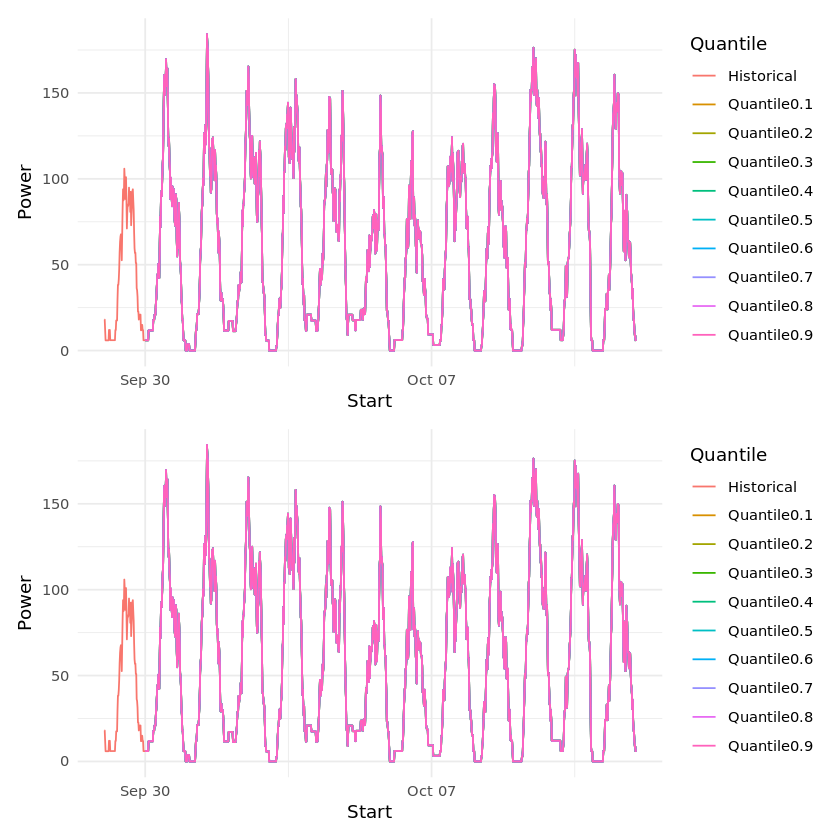

In [38]:
p <- tmp %>% 
filter(Start %within% lubridate::interval(start = ymd_hms('2019-09-29 00:00:00'), 
                                       end = ymd_hms('2019-10-11 23:59:00'))) %>% 
ggplot() +
geom_line(aes(Start, Power, color=Quantile))

p/p

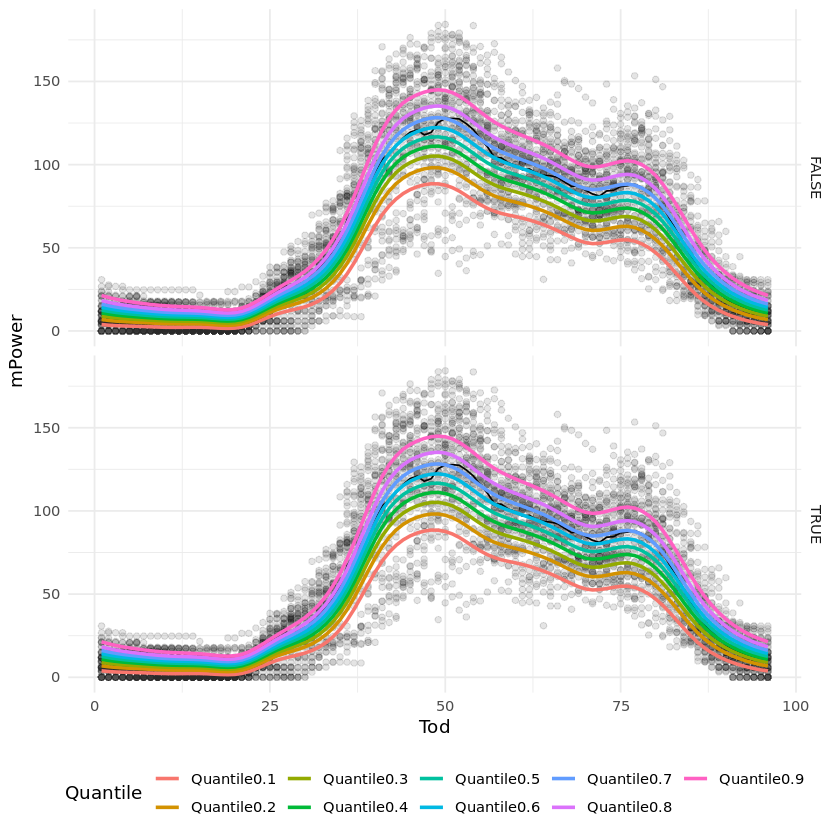

In [13]:
results.gamlss %>% group_by(Tod, Quantile) %>% 
mutate(Prev = mean(Prev), mPower=mean(Power)) %>% 
ggplot()+
geom_line(aes(Tod, mPower))+
geom_point(aes(Tod, Power), alpha=0.01)+
geom_line(aes(Tod, Prev, color=Quantile), size=1)+
theme(legend.position='bottom')+
facet_grid(Meteo ~ .)

### Métriques

In [14]:
results.gamlss <- results.gamlss %>% filter(Meteo == T) %>% select(-Meteo)

In [16]:
Results_quantiles <- results.gamlss %>% group_by(Quantile) %>% 
summarize(Cov = couverture(Power, Prev),
          Pinb = pinball_loss(Power, Prev, tau = parse_number(Quantile))) %>% 
mutate(Quantile = paste0('q', parse_number(Quantile)*100)) %>% 
mutate(Model = 'GAMlss') %>% rbind(Results_quantiles)

`summarise()` ungrouping output (override with `.groups` argument)


In [17]:
Results_quantiles

Quantile,Cov,Pinb,Model
q10,0.1123512,2.493091,GAMlss
q20,0.2070312,4.046261,GAMlss
q30,0.3022693,5.112566,GAMlss
q40,0.3932292,5.765168,GAMlss
q50,0.4778646,6.058445,GAMlss
q60,0.5582217,5.988746,GAMlss
q70,0.6369048,5.533785,GAMlss
q80,0.7137277,4.582053,GAMlss
q90,0.8149182,3.004087,GAMlss
q10,0.1149554,2.480639,Persistance


In [72]:
my_nRPS <- my_nRPS %>% rbind(data.frame(Model = 'GAMlss',
                   nRPS = nRPS(Y = results.gamlss %>% spread(key = Quantile, value=Prev) %>% pull(Power),  
     prevs_quantile = results.gamlss %>% spread(key = Quantile, value=Prev) %>% select(starts_with('Q')),  
     niveau_quantile = seq(0.1, 0.9, 0.1))))

In [73]:
my_nRPS

Model,nRPS
Persistance,0.2085631
GAMlss,0.2039934


# QGAM

In [143]:
results.qgam <- readRDS('../Results/Results_qgam_old.RDS') %>% select(Start, Power, Tod, starts_with('Prev'),
                                                                      Meteo, Learning_rate)

In [21]:
results.qgam <- results.qgam %>% filter(Meteo == T, Learning_rate == F) %>% select(-Meteo, -Learning_rate)

In [ ]:
results.gamlss %>% group_by(Tod, Quantile) %>% 
mutate(Prev = mean(Prev), mPower=mean(Power)) %>% 
ggplot()+
geom_line(aes(Tod, mPower))+
geom_point(aes(Tod, Power), alpha=0.01)+
geom_line(aes(Tod, Prev, color=Quantile), size=1)+
theme(legend.position='bottom')+
facet_grid(Meteo ~ .)

In [153]:
results.qgam2 <- readRDS('../Results/Results_qgam_discrete.RDS')

### Prévisions

In [147]:
results.qgam2 %>% head

Start,Power,temperature,wind,humidity,temperature98,temperature997,temperature7,Hour,Tod,...,Holiday,Prev0.1,Prev0.2,Prev0.3,Prev0.4,Prev0.5,Prev0.6,Prev0.7,Prev0.8,Prev0.9
2019-09-30 00:00:00,6.007731,13.635,3.513333,69.59592,15.67447,18.68246,13.82349,0,1,...,FALSE,-1.768295,1.6130537,3.980927,5.641376,7.259956,8.715926,10.437834,12.89591,16.79231
2019-09-30 00:15:00,6.007731,13.560,3.413333,70.10467,15.63218,18.66709,13.74444,0,2,...,FALSE,-2.017269,1.3000620,3.543773,5.144362,6.749832,8.151467,9.836365,12.29558,16.32233
2019-09-30 00:30:00,6.007731,13.485,3.313333,70.61342,15.58923,18.65155,13.66661,0,3,...,FALSE,-2.243988,0.9992994,3.144491,4.717490,6.312327,7.676084,9.288900,11.69227,15.82078
2019-09-30 00:45:00,6.007731,13.410,3.213333,71.12217,15.54565,18.63582,13.58963,0,4,...,FALSE,-2.444709,0.7250815,2.793418,4.358820,5.944848,7.283969,8.809101,11.11974,15.29677
2019-09-30 01:00:00,6.007731,13.335,3.113333,71.63092,15.50144,18.61992,13.51324,1,5,...,FALSE,-2.615712,0.4917051,2.500879,4.066407,5.644794,6.969312,8.410622,10.61174,14.75941
2019-09-30 01:15:00,6.007731,13.260,3.013333,72.13967,15.45661,18.60384,13.43727,1,6,...,FALSE,-2.753288,0.3134491,2.277185,3.838294,5.409561,6.726296,8.107107,10.20198,14.21779


### Métriques

In [154]:
results.qgam <- results.qgam %>% mutate_at(vars(starts_with('Prev')), function(x) ifelse(x < 0, 0, x))
results.qgam2 <- results.qgam2 %>% mutate_at(vars(starts_with('Prev')), function(x) ifelse(x < 0, 0, x))                                           

In [158]:
results.qgam2 %>% s
gather(-Start, -Power, -Tod, key='Quantile', value='Prev') %>% 
group_by(Quantile) %>% 
summarize(Cov = couverture(Power, Prev), 
          Pinb = pinball_loss(Power, Prev, tau = parse_number(Quantile))) %>% 
mutate(Quantile = paste0('q', parse_number(Quantile)*100),
       Model = 'QGAM2')

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

ERROR: Error: Problem with `summarise()` input `Cov`.
✖ non-numeric argument to binary operator
ℹ Input `Cov` is `couverture(Power, Prev)`.
ℹ The error occurred in group 1: Quantile = "Day".


In [160]:
Results_quantiles <- Results_quantiles %>% rbind(results.qgam2 %>% select(Start, Power, Tod, starts_with('Prev'))%>%
gather(-Start, -Power, -Tod, key='Quantile', value='Prev') %>% 
group_by(Quantile) %>% 
summarize(Cov = couverture(Power, Prev), 
          Pinb = pinball_loss(Power, Prev, tau = parse_number(Quantile))) %>% 
mutate(Quantile = paste0('q', parse_number(Quantile)*100),
       Model = 'QGAM2'))

`summarise()` ungrouping output (override with `.groups` argument)


In [161]:
my_nRPS <- my_nRPS %>% rbind(data.frame(Model = 'QGAM',
                   nRPS = nRPS(Y = results.qgam2 %>% pull(Power),  
     prevs_quantile = results.qgam2 %>% select(starts_with('Prev')),  
     niveau_quantile = seq(0.1, 0.9, 0.1))))

In [162]:
my_nRPS

Model,nRPS
Persistance,0.2085631
GAMlss,0.2039934
QGAM,0.2007506
SARIMA+GMM,0.2439823
QGAM,0.2005108


# BOTTOM UP

In [29]:
results.bu <- read_csv('/home/G77675/Desktop/MOBILITE/MOBILITE 2024/Data/bottom up/profiles_proba_dates_test_final.csv')

Parsed with column specification:
cols(
  Start = col_datetime(format = ""),
  mean = col_double(),
  q10 = col_double(),
  q20 = col_double(),
  q30 = col_double(),
  q40 = col_double(),
  q50 = col_double(),
  q60 = col_double(),
  q70 = col_double(),
  q80 = col_double(),
  q90 = col_double(),
  model_number = col_double()
)


In [32]:
temp <- results.bu %>% filter(Start %within% test_dates) %>%
mutate(Method = ifelse(Start %within% test_dates[[1]], 20,
                      ifelse(Start %within% test_dates[[2]], 21,
                             ifelse(Start %within% test_dates[[3]], 22, 23)))) %>% 
filter(Method == model_number) %>% select(-Method) %>% 
mutate(Power = load %>% filter(Start %within% test_dates) %>% pull(Power))

In [30]:
Results_quantiles <- temp %>% 
gather(-Start, -mean, -model_number, -Power, key='Quantile', value='Prev') %>%
group_by(Quantile) %>%
summarize(Cov = couverture(Power, Prev),
          Pinb = pinball_loss(Power, Prev, tau = parse_number(Quantile)*0.01)) %>% 
mutate(Model = 'SARIMA + GMM') %>% rbind(Results_quantiles)

`summarise()` ungrouping output (override with `.groups` argument)


In [76]:
my_nRPS <- my_nRPS %>% rbind(data.frame(Model = 'SARIMA+GMM',
                           nRPS = nRPS(Y = temp %>% pull(Power),  
     prevs_quantile = temp %>% select(starts_with('q')),  
     niveau_quantile = seq(0.1, 0.9, 0.1))))

In [77]:
my_nRPS

Model,nRPS
Persistance,0.2085631
GAMlss,0.2039934
QGAM,0.2007506
SARIMA+GMM,0.2439823


# Synthèse

In [33]:
Results_quantiles %>% head

Quantile,Cov,Pinb,Model
q10,0.07942708,2.972178,SARIMA + GMM
q20,0.14583333,4.828245,SARIMA + GMM
q30,0.21279762,6.121799,SARIMA + GMM
q40,0.28757440,6.941254,SARIMA + GMM
q50,0.37741815,7.297166,SARIMA + GMM
q60,0.48009673,7.142597,SARIMA + GMM


Warning message:
“Removed 4 row(s) containing missing values (geom_path).”

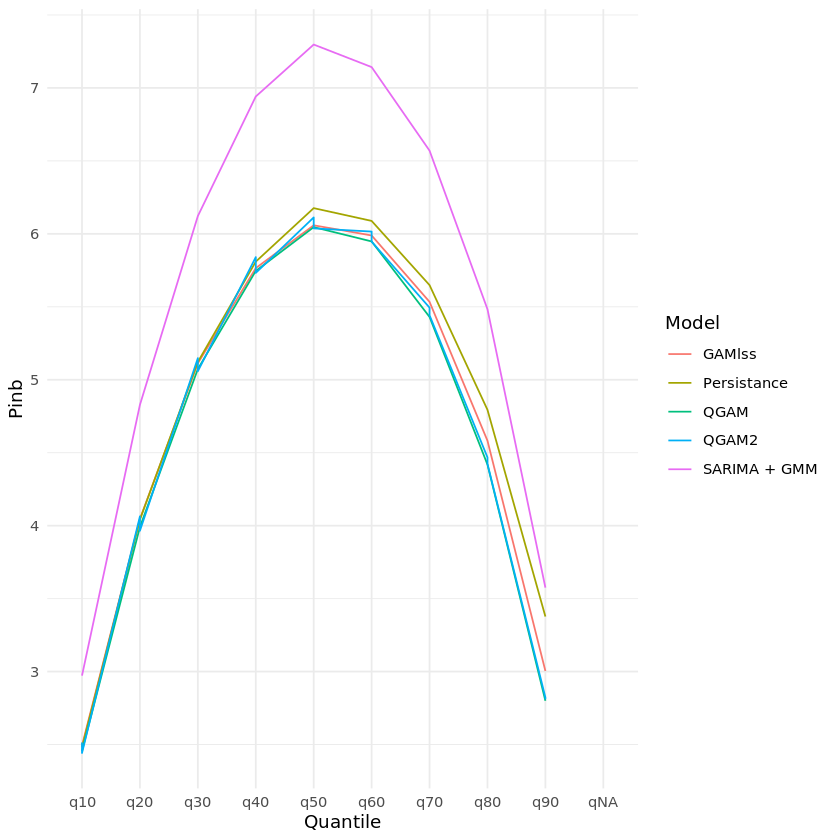

In [163]:
Results_quantiles %>% ggplot()+
geom_line(aes(Quantile, Pinb, color=Model, group=Model))

Warning message:
“4 parsing failures.
row col expected actual
 37  -- a number    qNA
 38  -- a number    qNA
 48  -- a number    qNA
 49  -- a number    qNA
”Warning message:
“Removed 4 rows containing missing values (geom_hline).”

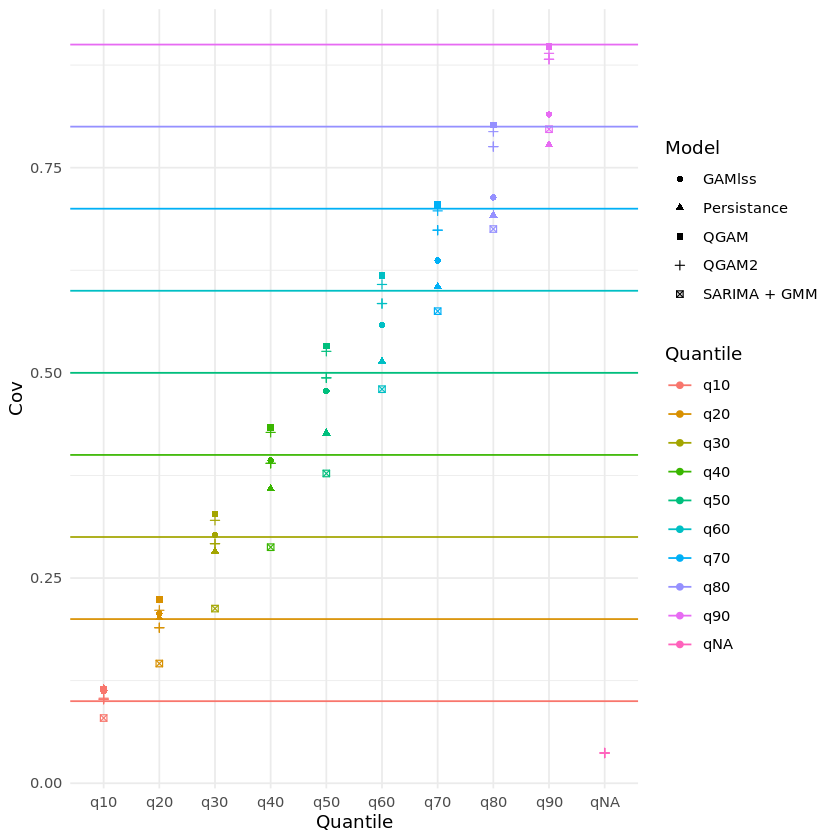

In [164]:
Results_quantiles %>% ggplot()+
geom_point(aes(Quantile, Cov, color=Quantile, shape = Model))+
geom_hline(aes(yintercept = parse_number(Quantile)*0.01, color=Quantile))

In [91]:
Results_quantiles %>% filter(Model == 'Persistance')

Quantile,Cov,Pinb,Model
q10,0.1149554,2.480639,Persistance
q20,0.2014509,4.041767,Persistance
q30,0.2825521,5.122245,Persistance
q40,0.3588170,5.809415,Persistance
q50,0.4267113,6.176054,Persistance
q60,0.5139509,6.088440,Persistance
q70,0.6050967,5.648483,Persistance
q80,0.6921503,4.793887,Persistance
q90,0.7777158,3.377217,Persistance


In [92]:
my_nRPS

Model,nRPS
Persistance,0.2085631
GAMlss,0.2039934
QGAM,0.2007506
SARIMA+GMM,0.2439823


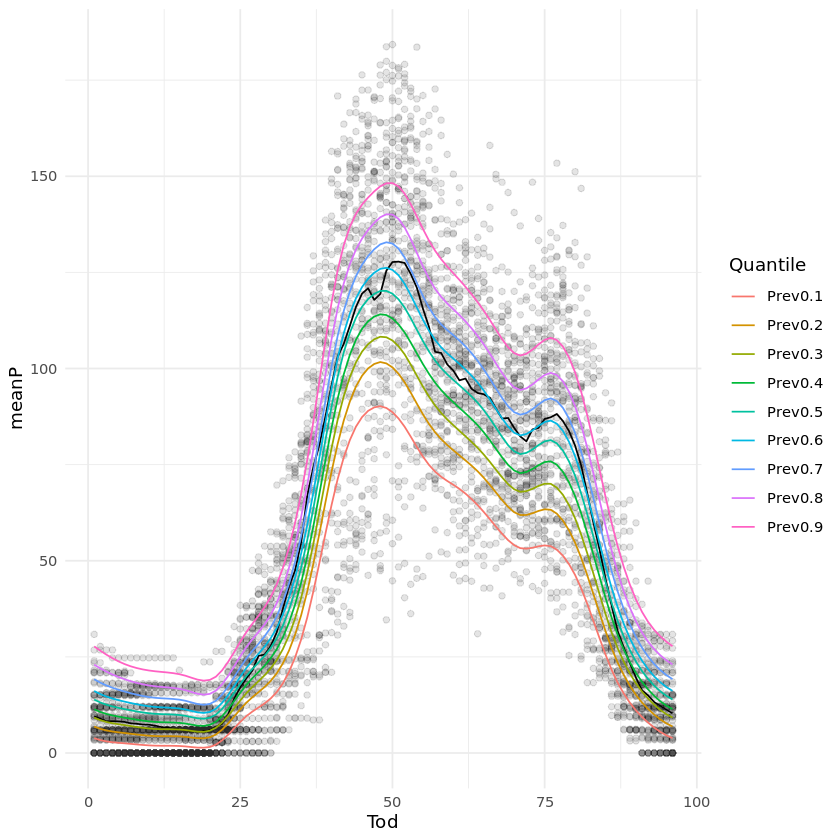

In [98]:
p1 <- results.qgam %>%
gather(-Start, -Power, -Tod, key='Quantile', value='Prev')%>%
group_by(Tod, Quantile) %>% 
mutate(meanP = mean(Power), Prev = mean(Prev)) %>%
ggplot()+
geom_line(aes(Tod, meanP))+
geom_point(aes(Tod, Power), alpha=0.01)+
geom_line(aes(Tod, Prev, color=Quantile))

In [135]:
temp %>% select(-mean, -model_number) %>% 
mutate(Tod = interval(floor_date(Start, unit='day'), Start) %/% dminutes(15) + 1,
       Weekday = ifelse(wday(Start) %in% c(1,7), 'Weekend', 'Workday')) %>% head

Start,q10,q20,q30,q40,q50,q60,q70,q80,q90,Power,Tod,Weekday
2019-09-30 00:00:00,0,0,0,0,0,0,0,0,0,6.007731,1,Workday
2019-09-30 00:15:00,0,0,0,0,0,0,0,0,0,6.007731,2,Workday
2019-09-30 00:30:00,0,0,0,0,0,0,0,0,0,6.007731,3,Workday
2019-09-30 00:45:00,0,0,0,0,0,0,0,0,0,6.007731,4,Workday
2019-09-30 01:00:00,0,0,0,0,0,0,0,0,0,6.007731,5,Workday
2019-09-30 01:15:00,0,0,0,0,0,0,0,0,0,6.007731,6,Workday


In [137]:
p2 <- temp %>% select(-mean, -model_number) %>% 
mutate(Tod = interval(floor_date(Start, unit='day'), Start) %/% dminutes(15) + 1,
       Weekday = ifelse(wday(Start) %in% c(1,7), 'Weekend', 'Workday')) %>% 
gather(-Start, -Power, -Tod, -Weekday, key='Quantile', value='Prev')%>%
mutate(Quantile = paste0('q', parse_number(Quantile)*100)) %>%
group_by(Tod, Quantile, Weekday) %>% 
mutate(meanP = mean(Power), Prev = mean(Prev)) %>%
ggplot()+
geom_line(aes(Tod, meanP))+
geom_point(aes(Tod, Power), alpha=0.01)+
geom_line(aes(Tod, Prev, color=Quantile), size=1)+
theme(legend.position='none')+
facet_grid(. ~ Weekday)

In [139]:
p1 <- results.qgam %>%
mutate(Weekday = ifelse(wday(Start) %in% c(1,7), 'Weekend', 'Workday')) %>% 
gather(-Start, -Power, -Tod, -Weekday, key='Quantile', value='Prev')%>%
mutate(Quantile = paste0('q', parse_number(Quantile)*100)) %>%
group_by(Tod, Quantile, Weekday) %>% 
mutate(meanP = mean(Power), Prev = mean(Prev)) %>%
ggplot()+
geom_line(aes(Tod, meanP))+
geom_point(aes(Tod, Power), alpha=0.01)+
geom_line(aes(Tod, Prev, color=Quantile), size=1)+
theme(legend.position='bottom')+
facet_grid(. ~ Weekday)

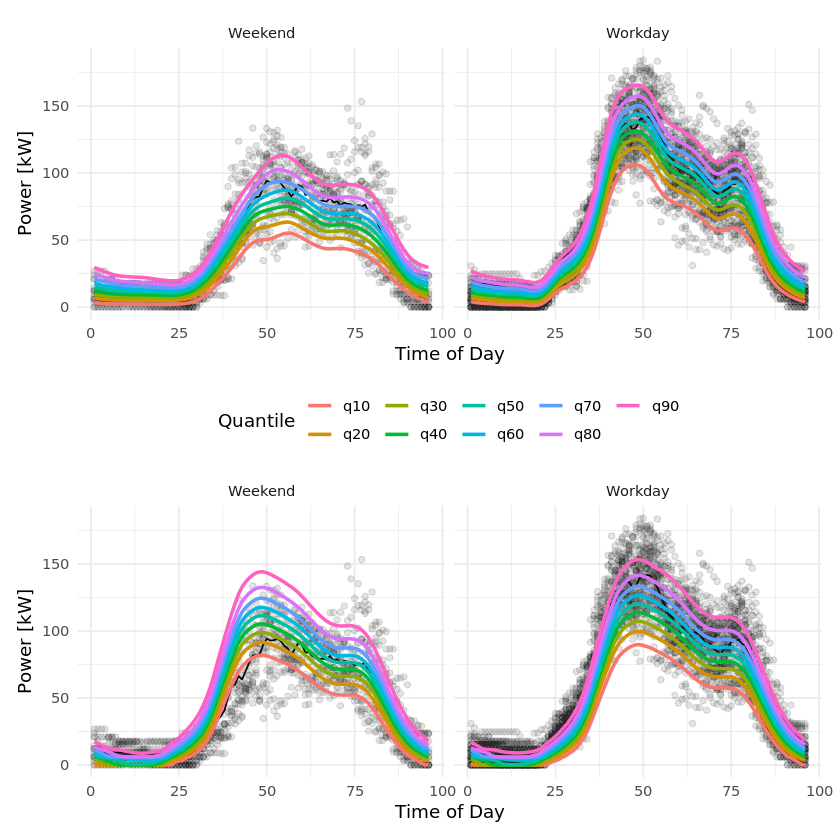

In [140]:
p1/p2 & ylab('Power [kW]') & xlab('Time of Day') 

In [122]:
library(patchwork) 

In [141]:
png(file="../Results/plot")
p1/p2 & ylab('Power [kW]') & xlab('Time of Day') 
dev.off()

png 
  2

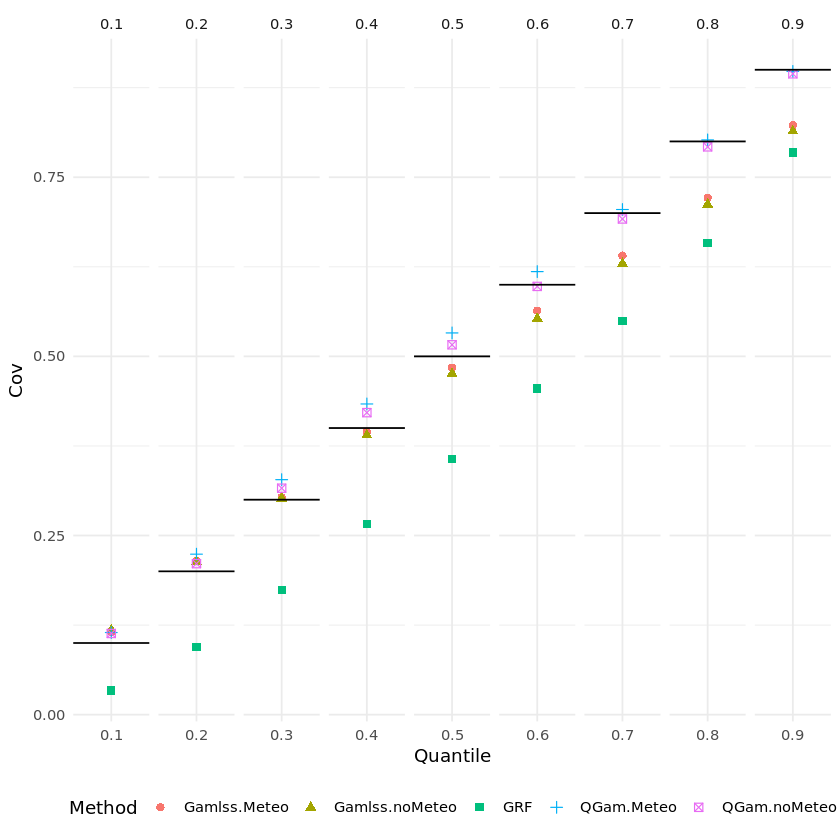

In [328]:
metrics %>% 
mutate(Quantile = parse_number(Quantile) %>% as.factor) %>% 
ggplot()+
geom_point(aes(Quantile, Cov, color=Method, shape=Method), size=2)+
geom_hline(aes(yintercept=0.1*as.numeric(Quantile)))+
theme(legend.position='bottom')+
facet_grid(.~ Quantile, scales = 'free')

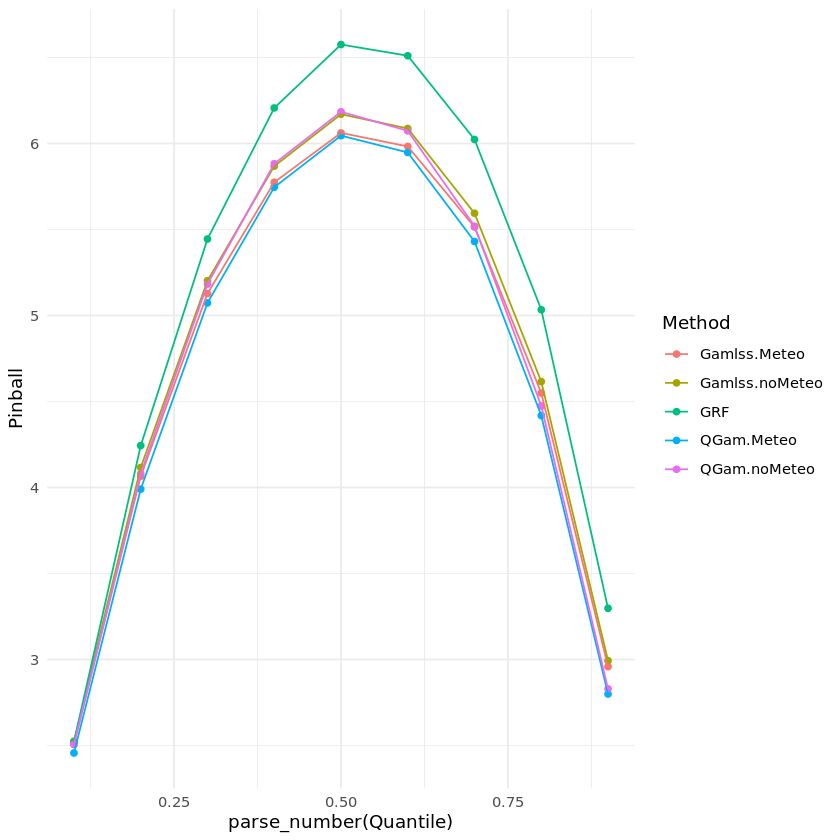

In [329]:
metrics %>% ggplot()+
geom_point(aes(parse_number(Quantile), Pinball, color=Method))+
geom_line(aes(parse_number(Quantile), Pinball, color=Method))

Warning message:
“Ignoring unknown aesthetics: groupe”

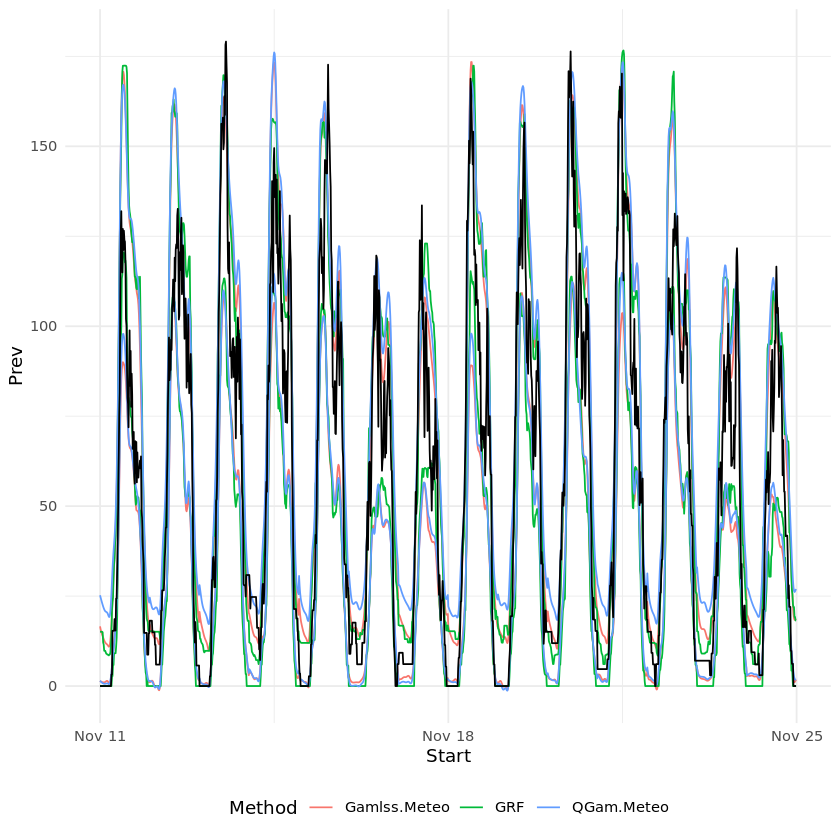

In [330]:
all_results %>% 
filter(Method %in% c('GRF', 'QGam.Meteo', 'Gamlss.Meteo')) %>%
filter(Start %within% test_dates[4]) %>%
filter(Start > ymd('2019-11-04')) %>%
filter(Quantile %in% c('Quantile0.1', 'Quantile0.9')) %>%
ggplot()+
geom_line(aes(Start, Prev, color=Method, groupe=Quantile))+
geom_line(aes(Start, Power))+
theme(legend.position='bottom')

`summarise()` regrouping output by 'Tod', 'Daytype', 'Method', 'Quantile' (override with `.groups` argument)


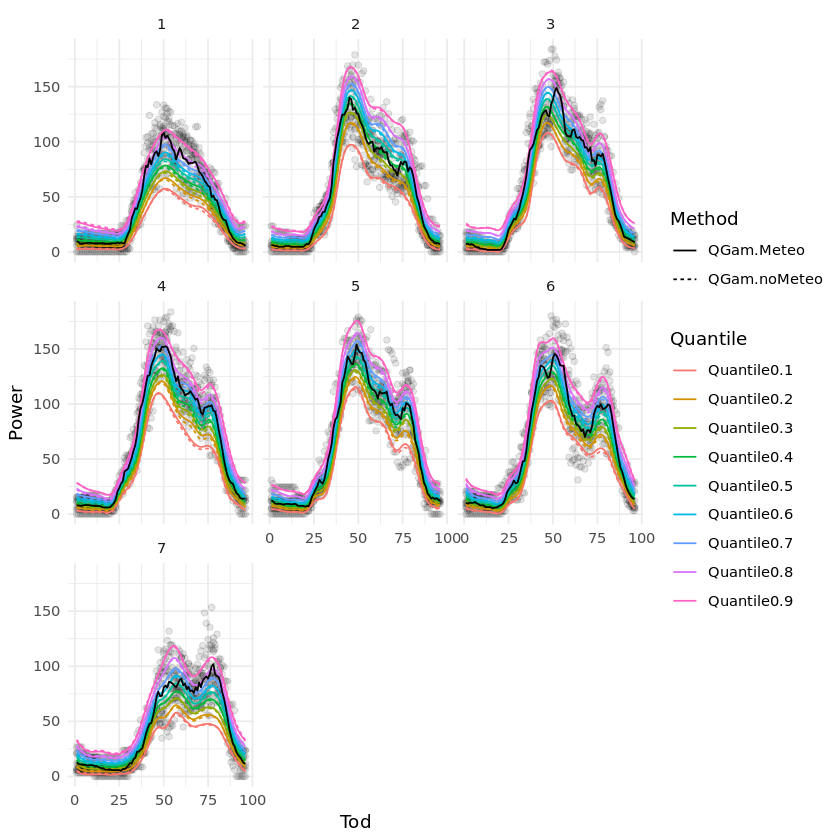

In [331]:
all_results %>%
filter(Method %in% c('QGam.noMeteo', 'QGam.Meteo')) %>%
group_by(Tod, Daytype = wday(Start), Method, Quantile) %>% 
summarize(meanP = mean(Power), Power=unique(Power), Prev = mean(Prev)) %>%
ungroup() %>%
ggplot()+
geom_point(data= . %>% select(Tod, Power, Daytype) %>% unique, aes(Tod, Power), alpha=0.1)+
geom_line(aes(Tod, Prev, color=Quantile, linetype=Method))+
geom_line( aes(Tod, meanP))+
facet_wrap(Daytype ~ ., nrow=3)

`summarise()` regrouping output by 'Tod', 'Daytype', 'Method', 'Quantile' (override with `.groups` argument)


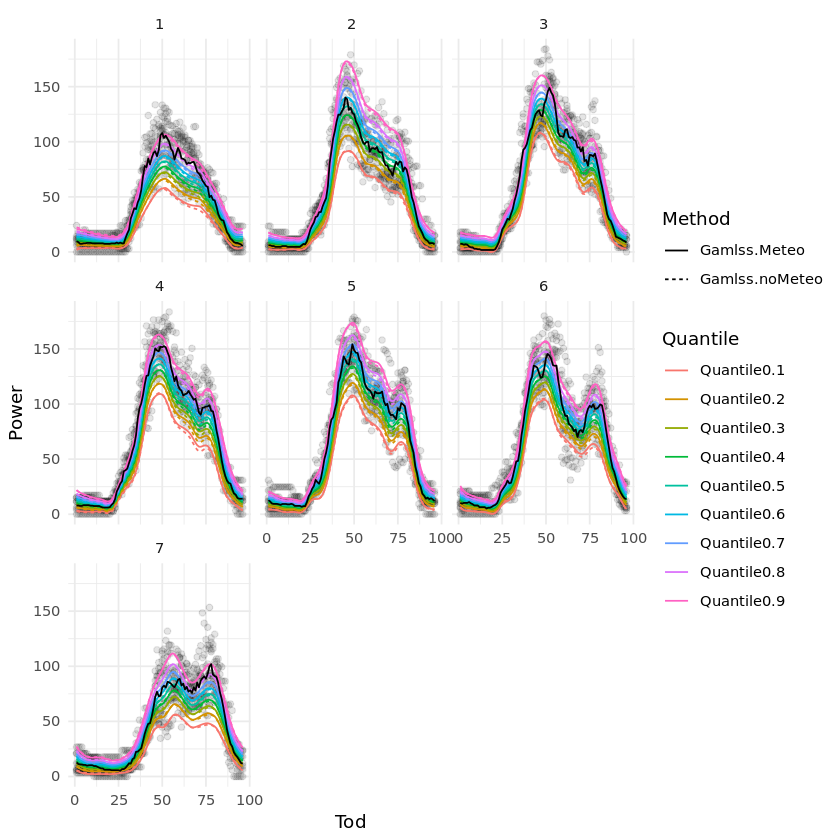

In [332]:
all_results %>%
filter(Method %in% c('Gamlss.noMeteo', 'Gamlss.Meteo')) %>%
group_by(Tod, Daytype = wday(Start), Method, Quantile) %>% 
summarize(meanP = mean(Power), Power=unique(Power), Prev = mean(Prev)) %>%
ungroup() %>%
ggplot()+
geom_point(data= . %>% select(Tod, Power, Daytype) %>% unique, aes(Tod, Power), alpha=0.1)+
geom_line(aes(Tod, Prev, color=Quantile, linetype=Method))+
geom_line( aes(Tod, meanP))+
facet_wrap(Daytype ~ ., nrow=3)

`summarise()` regrouping output by 'Tod', 'Daytype', 'Method', 'Quantile' (override with `.groups` argument)


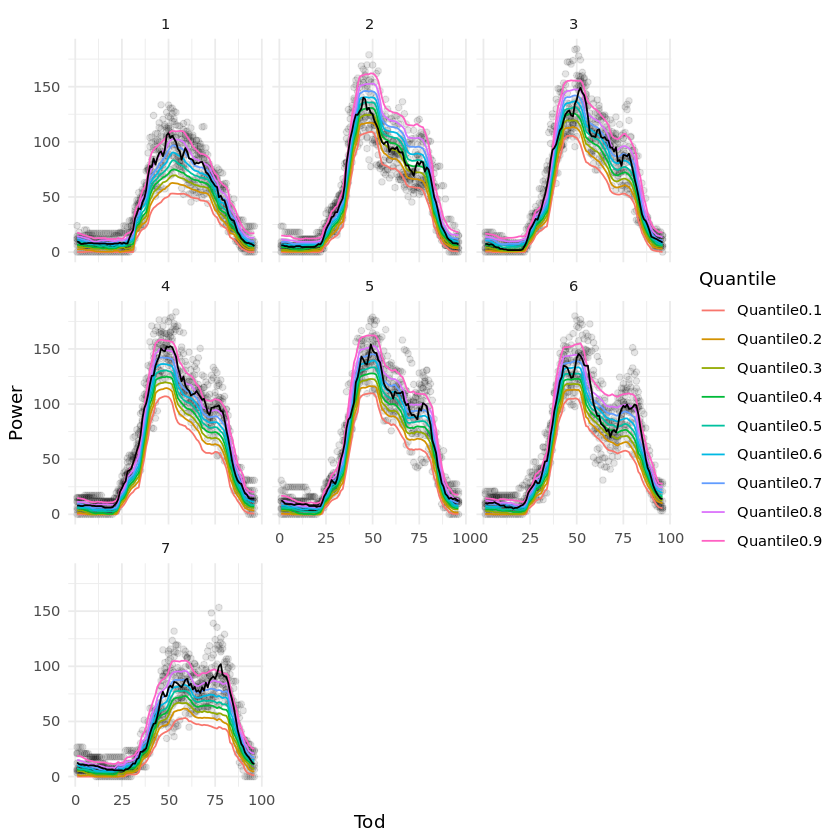

In [333]:
all_results %>%
filter(Method %in% c('GRF')) %>%
group_by(Tod, Daytype = wday(Start), Method, Quantile) %>% 
summarize(meanP = mean(Power), Power=unique(Power), Prev = mean(Prev)) %>%
ungroup() %>%
ggplot()+
geom_point(data= . %>% select(Tod, Power, Daytype) %>% unique, aes(Tod, Power), alpha=0.1)+
geom_line(aes(Tod, Prev, color=Quantile))+
geom_line( aes(Tod, meanP))+
facet_wrap(Daytype ~ ., nrow=3)

In [337]:
results_gp <- all_results %>% 
spread(key=Quantile, value=Prev) %>% 
mutate(Date = date(Start), heure = format(Start, "%H:%M")) %>% 
select(Date, heure, Power, Quantile0.1, Quantile0.9, Method) %>% 
rename(sup = Quantile0.9, inf = Quantile0.1, obs=Power) %>% 
select(sup, inf, obs, Date, heure, Method)

In [338]:
results_gp %>% saveRDS('../Results/resultats_format_GP.RDS')

In [340]:
results_gp %>% head

sup,inf,obs,Date,heure,Method
19.01203,0.61715604,6.007731,2019-09-30,00:00,QGam.noMeteo
18.57742,0.40104457,6.007731,2019-09-30,00:15,QGam.noMeteo
18.07285,0.18336443,6.007731,2019-09-30,00:30,QGam.noMeteo
17.52932,-0.02239138,6.007731,2019-09-30,00:45,QGam.noMeteo
16.97784,-0.20272987,6.007731,2019-09-30,01:00,QGam.noMeteo
16.44941,-0.34415803,6.007731,2019-09-30,01:15,QGam.noMeteo


# Bottom up

In [68]:
a <- read_csv('/home/G77675/Desktop/MOBILITE/MOBILITE 2024/chaine_PO/1_prev/2. R/temp/palo_alto/gmm/profiles_proba_modelqgam_dates_test.csv')

Parsed with column specification:
cols(
  Start = col_datetime(format = ""),
  mean = col_double(),
  q10 = col_double(),
  q20 = col_double(),
  q30 = col_double(),
  q40 = col_double(),
  q50 = col_double(),
  q60 = col_double(),
  q70 = col_double(),
  q80 = col_double(),
  q90 = col_double(),
  model_number = col_double()
)


In [83]:
a %>% filter(Start %within% test_dates) %>% select(Start, starts_with('q')) %>% 
full_join(load %>% filter(Start %within% test_dates) %>% select(Start, Power),
          by='Start') %>% 
gather(-Start, -Power, key='Quantile', value='Prev') %>% 
group_by(Quantile) %>%
summarize(prinball = pinball_loss(Power, Prev, tau = parse_number(Quantile)*0.01),
          cov = couverture(Power, Prev))

`summarise()` ungrouping output (override with `.groups` argument)


Quantile,prinball,cov
q10,2.732899,0.0734747
q20,4.487114,0.1372768
q30,5.703606,0.2072173
q40,6.482065,0.2812500
q50,6.807302,0.3709077
q60,6.682350,0.4763765
q70,6.145631,0.5708705
q80,5.112979,0.6757812
q90,3.319355,0.7981771


### Yvenn old 

In [84]:
aa <- read_csv('/home/G77675/Desktop/MOBILITE/MOBILITE 2024/Data/bottom up/profiles_proba_full_dates_kFold.csv')

Parsed with column specification:
cols(
  Start = col_datetime(format = ""),
  mean = col_double(),
  q10 = col_double(),
  q20 = col_double(),
  q30 = col_double(),
  q40 = col_double(),
  q50 = col_double(),
  q60 = col_double(),
  q70 = col_double(),
  q80 = col_double(),
  q90 = col_double(),
  model_number = col_double()
)


In [86]:
aa %>% filter(Start %within% test_dates) %>% select(Start, starts_with('q')) %>% 
full_join(load %>% filter(Start %within% test_dates) %>% select(Start, Power),
          by='Start') %>% 
gather(-Start, -Power, key='Quantile', value='Prev') %>% 
group_by(Quantile) %>%
summarize(prinball = pinball_loss(Power, Prev, tau = parse_number(Quantile)*0.01),
          cov = couverture(Power, Prev))

`summarise()` ungrouping output (override with `.groups` argument)


Quantile,prinball,cov
q10,2.978883,0.0796131
q20,4.833935,0.1437872
q30,6.115091,0.2068452
q40,6.921278,0.2792039
q50,7.263544,0.3656994
q60,7.102654,0.4683780
q70,6.498623,0.5578497
q80,5.389270,0.6648065
q90,3.500602,0.7909226
